In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')
sns.set()  # domyślny wygląd wykresów matplotlib będzie zmieniony na ustawienia z seaborn

# Target: Forecast daily traffic for a week: D+1 to D+7

__DATASET__: Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2015-2018.
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

## Plan
1. Download raw data
2. Verify the data are time series. If not, bring them to time series with the required frequency
3. Exploratory data analysis - understand what data tells us
4. Handle missing values
5. Encode categorical variables
6. Features Engineering (based on date and target itself)
7. Baseline model - Naive Forecast
8. Prepare framework for models training using walk forward validation
9. Models training and validation

## Download the raw data

In [2]:
raw_df = pd.read_csv('metro_data_1.csv')
raw_df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [3]:
raw_df.tail()

,date_time,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
32228,2018-09-30 19:00:00,283.45,0.0,0.0,75,Clouds,broken clouds,3543
32229,2018-09-30 20:00:00,282.76,0.0,0.0,90,Clouds,overcast clouds,2781
32230,2018-09-30 21:00:00,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159
32231,2018-09-30 22:00:00,282.09,0.0,0.0,90,Clouds,overcast clouds,1450
32232,2018-09-30 23:00:00,282.12,0.0,0.0,90,Clouds,overcast clouds,954


In [4]:
raw_df.shape

(32233, 8)

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32233 entries, 0 to 32232
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date_time            32233 non-null  object 
 1   temp                 32233 non-null  float64
 2   rain_1h              32233 non-null  float64
 3   snow_1h              32233 non-null  float64
 4   clouds_all           32233 non-null  int64  
 5   weather_main         32233 non-null  object 
 6   weather_description  32233 non-null  object 
 7   traffic_volume       32233 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.0+ MB


In [6]:
raw_df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,32233.000000,32233.000000,32233.000000,32233.000000,32233.000000
mean,282.955665,0.420472,0.000333,47.290293,3258.114851
std,12.120323,54.766368,0.009986,39.734834,1973.534323
min,243.390000,0.000000,0.000000,0.000000,0.000000
25%,273.940000,0.000000,0.000000,1.000000,1196.000000
50%,285.190000,0.000000,0.000000,40.000000,3412.000000
75%,292.750000,0.000000,0.000000,90.000000,4912.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


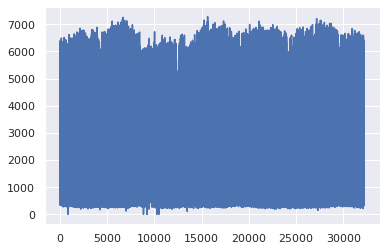

In [7]:
plt.plot(raw_df['traffic_volume'])
plt.show()

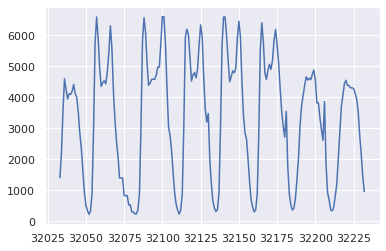

In [8]:
plt.plot(raw_df['traffic_volume'].tail(200));

## Verify data are time series
* the first column considered as a time index
* the column is sorted
* the column has stable frequency

1. The first column is considered as a time index - __date_time__

In [9]:
df = raw_df.set_index('date_time')
df.index = pd.to_datetime(df.index)
df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,
2015-06-11 20:00:00,287.586,0.0,0.0,92,Rain,light rain,2886
2015-06-12 18:00:00,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2015-06-12 20:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3095
2015-06-12 21:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3299
2015-06-13 21:00:00,294.840,0.0,0.0,76,Clouds,broken clouds,3040


<AxesSubplot:xlabel='date_time'>

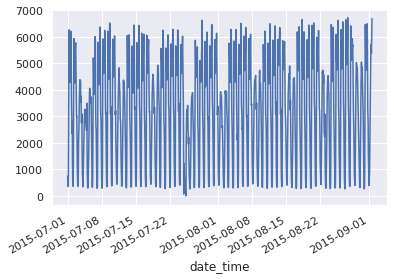

In [10]:
df.loc['2015-07-01':'2015-09-01', 'traffic_volume'].plot()

## Task 1
* implement transformer __MakeTSTransformer__ which makes the dataset timeseries 

In [11]:
class MakeTSTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, index_column='date_time'):
        self.index_column = index_column
        
    def fit(self, X, y=None):   
        return self 
    
    def transform(self, X, y=None):
        X = X.set_index(self.index_column)
        X.index = pd.to_datetime(X.index)
        return X

In [12]:
ts_transformer = MakeTSTransformer(index_column='date_time')
df = ts_transformer.fit_transform(raw_df)

In [13]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,
2015-06-11 20:00:00,287.586,0.0,0.0,92,Rain,light rain,2886
2015-06-12 18:00:00,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2015-06-12 20:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3095
2015-06-12 21:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3299
2015-06-13 21:00:00,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [14]:
raw_df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,294.840,0.0,0.0,76,Clouds,broken clouds,3040


2. Column is __sorted__


In [15]:
# if sorted column is equal to the orginal column, it means the column is sorted properly
(df.index == df.index.sort_values()).all()

# if not, then we can sort it 
# df = df.sort_index()

True

3. Stable __frequency__

In [16]:
# difference between all rows is 1H (1D etc)
print(pd.infer_freq(df.index))

None


**Conclusion: the data are not time series. Modifications are required including resampling to daily data.**

# Exploratory Data Analysis
Here we need to decide which columns we can remove and what to do with other columns.

In [17]:
df.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume'],
      dtype='object')

In [18]:
cat_columns = df.select_dtypes(exclude=np.number).columns.tolist()
cat_columns

['weather_main', 'weather_description']

In [19]:
# values for category columns
for col in cat_columns:
    print(f'{col}: {df[col].nunique()}')
    print(df[col].unique())
    print()

weather_main: 11
['Rain' 'Clear' 'Clouds' 'Haze' 'Thunderstorm' 'Mist' 'Fog' 'Drizzle'
 'Smoke' 'Snow' 'Squall']

weather_description: 37
['light rain' 'Sky is Clear' 'sky is clear' 'broken clouds' 'few clouds'
 'scattered clouds' 'moderate rain' 'haze' 'proximity thunderstorm' 'mist'
 'fog' 'heavy intensity rain' 'drizzle' 'thunderstorm'
 'light intensity drizzle' 'overcast clouds'
 'thunderstorm with heavy rain' 'very heavy rain' 'smoke'
 'proximity shower rain' 'thunderstorm with light rain'
 'proximity thunderstorm with drizzle' 'thunderstorm with rain'
 'thunderstorm with light drizzle' 'heavy intensity drizzle'
 'proximity thunderstorm with rain' 'light rain and snow' 'light snow'
 'snow' 'heavy snow' 'light intensity shower rain'
 'thunderstorm with drizzle' 'SQUALLS' 'freezing rain' 'shower drizzle'
 'light shower snow' 'sleet']



### Weather

In [20]:
for value in df['weather_main'].unique():
    weather_descr = df[df['weather_main']==value]['weather_description'].unique()
    print(f'{value} : {weather_descr}')
    print()

Rain : ['light rain' 'moderate rain' 'heavy intensity rain' 'very heavy rain'
 'proximity shower rain' 'light intensity shower rain' 'freezing rain']

Clear : ['Sky is Clear' 'sky is clear']

Clouds : ['broken clouds' 'few clouds' 'scattered clouds' 'overcast clouds']

Haze : ['haze']

Thunderstorm : ['proximity thunderstorm' 'thunderstorm' 'thunderstorm with heavy rain'
 'thunderstorm with light rain' 'proximity thunderstorm with drizzle'
 'thunderstorm with rain' 'thunderstorm with light drizzle'
 'proximity thunderstorm with rain' 'thunderstorm with drizzle']

Mist : ['mist']

Fog : ['fog']

Drizzle : ['drizzle' 'light intensity drizzle' 'heavy intensity drizzle'
 'shower drizzle']

Smoke : ['smoke']

Snow : ['light rain and snow' 'light snow' 'snow' 'heavy snow'
 'light shower snow' 'sleet']

Squall : ['SQUALLS']



- haze => mgła
- mist => zamglenie, mgła
- fog => mgła
- drizzle => mżawka
- squall => szkwał

Weather description is just extension of 'weather_main' thus it can be removed. Let's consider the __'weather_main'__.

In [21]:
df['weather_main'].value_counts()

weather_main
Clear           9656
Clouds          8594
Mist            4191
Rain            3853
Snow            1926
Drizzle         1454
Haze             993
Thunderstorm     846
Fog              699
Smoke             20
Squall             1
Name: count, dtype: int64

In [22]:
df['weather_main'].value_counts() / df.shape[0] * 100

weather_main
Clear           29.956876
Clouds          26.662116
Mist            13.002203
Rain            11.953588
Snow             5.975243
Drizzle          4.510905
Haze             3.080694
Thunderstorm     2.624639
Fog              2.168585
Smoke            0.062048
Squall           0.003102
Name: count, dtype: float64

We need to group the categories with low frequency (e.g., Squall, Smoke etc.). Threshold to be set.

In [23]:
# precipitation - rain
(df['rain_1h'].value_counts() / df.shape[0] * 100).head()

rain_1h
0.00    94.021655
0.25     1.405392
0.51     0.434337
0.30     0.291627
1.02     0.276115
Name: count, dtype: float64

In [24]:
# snow
(df['snow_1h'].value_counts() / df.shape[0] * 100).head()

snow_1h
0.00    99.804548
0.05     0.043434
0.06     0.037229
0.51     0.018614
0.25     0.018614
Name: count, dtype: float64

In [25]:
# clouds
(df['clouds_all'].value_counts() / df.shape[0] * 100).head(10)

clouds_all
90    35.119288
1     30.595973
75    11.339311
40     9.490274
5      3.242019
20     3.155152
0      2.947290
92     0.915211
8      0.412621
12     0.394006
Name: count, dtype: float64

<AxesSubplot:>

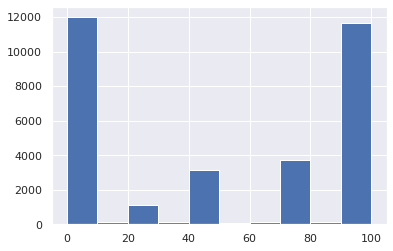

In [26]:
df['clouds_all'].hist()

### Temperature

<AxesSubplot:>

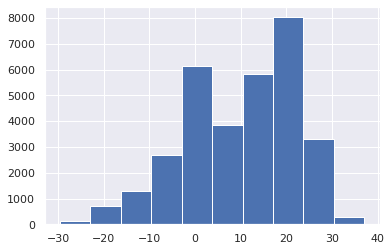

In [27]:
(df['temp']  -273).hist()  # transformacja do stopni Celsjusza

In [28]:
df['temp'].corr(df['traffic_volume'])  # korelacja jest niska, więc decydujemy się ignorować
# ANOTHER IDEA: transform temperature into binary column - anomalies or fine temperature

0.12475002714390386

## Conclusion:
1. 'Weather_main' => categories to be reduced based on the 10% threshold to reduce dimensionality.
2. __Columns to remove__:
    - 'rain_1h' - low variance, redundant;
    - 'snow_1h' - very low variance, redundant;
    - 'clouds_all' - redundant, not meaningful;
    - 'weather_description' - redundant.
    - temp - very low correlation

## Task 2
* implement __RemoveColumnsTransformer__ for columns dropping
* implement pipeline with __MakeTSTransfomer__ and columns dropping transfomer
* transform the raw data and check the result

In [29]:
raw_df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [30]:
class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X.drop(self.columns_to_remove, axis=1)

In [31]:
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description']))
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description']))])

In [32]:
pipeline.transform(raw_df).head()

,weather_main,traffic_volume
date_time,,
2015-06-11 20:00:00,Rain,2886
2015-06-12 18:00:00,Clear,4380
2015-06-12 20:00:00,Clear,3095
2015-06-12 21:00:00,Clear,3299
2015-06-13 21:00:00,Clouds,3040


## Main Weather

In [33]:
df['weather_main'].value_counts(normalize=True) * 100

weather_main
Clear           29.956876
Clouds          26.662116
Mist            13.002203
Rain            11.953588
Snow             5.975243
Drizzle          4.510905
Haze             3.080694
Thunderstorm     2.624639
Fog              2.168585
Smoke            0.062048
Squall           0.003102
Name: proportion, dtype: float64

## Task 3
* create __WeatherTransformer__
* all the categories but ['Clear', 'Clouds', 'Mist', 'Rain'] go to the new category 'Other'
* create pipeline with 3 steps: __MakeTSTransformer__, __RemoveColumnsTransformer__, __WeatherTransformer__
* save the result to __df_reduced__

In [34]:
# ANOTHER IDEA: set threshold and change values below threshold (e.g., threshold = 0.1)
class WeatherTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, categories: list, column='weather_main'):
        self.categories = categories
        self.column = column
        
    def fit(self, X, y=None):   
        return self 
    
    def transform(self, X, y=None):
        X[self.column] = X[self.column].apply(lambda x: 'Other' if x not in self.categories else x) 
        return X

In [35]:
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('weather_transformer', WeatherTransformer(categories=['Clear', 'Clouds', 'Mist', 'Rain']))
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description'])),
                ('weather_transformer',
                 WeatherTransformer(categories=['Clear', 'Clouds', 'Mist',
                                                'Rain']))])

In [36]:
df_reduced = pipeline.transform(raw_df)
df_reduced.head()

,weather_main,traffic_volume
date_time,,
2015-06-11 20:00:00,Rain,2886
2015-06-12 18:00:00,Clear,4380
2015-06-12 20:00:00,Clear,3095
2015-06-12 21:00:00,Clear,3299
2015-06-13 21:00:00,Clouds,3040


In [37]:
df_reduced['weather_main'].unique()

array(['Rain', 'Clear', 'Clouds', 'Other', 'Mist'], dtype=object)

In [38]:
df_reduced['weather_main'].value_counts(normalize=True) * 100

weather_main
Clear     29.956876
Clouds    26.662116
Other     18.425216
Mist      13.002203
Rain      11.953588
Name: proportion, dtype: float64

We have less columns now. Thus, resampling will cause less challenges.

## Why the frequency is not stable?
* missing indexes
* duplicates

<AxesSubplot:xlabel='date_time'>

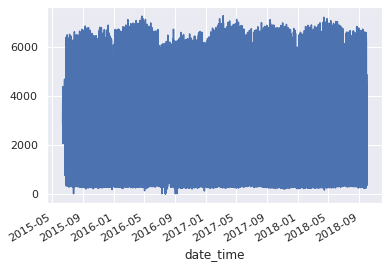

In [39]:
df_reduced['traffic_volume'].plot()

In [40]:
df_reduced.loc['2015-01':].head(10)

,weather_main,traffic_volume
date_time,,
2015-06-11 20:00:00,Rain,2886
2015-06-12 18:00:00,Clear,4380
2015-06-12 20:00:00,Clear,3095
2015-06-12 21:00:00,Clear,3299
2015-06-13 21:00:00,Clouds,3040
2015-06-13 23:00:00,Clouds,2051
2015-06-14 20:00:00,Rain,2909
2015-06-19 18:00:00,Clear,4681
2015-06-20 18:00:00,Rain,4045


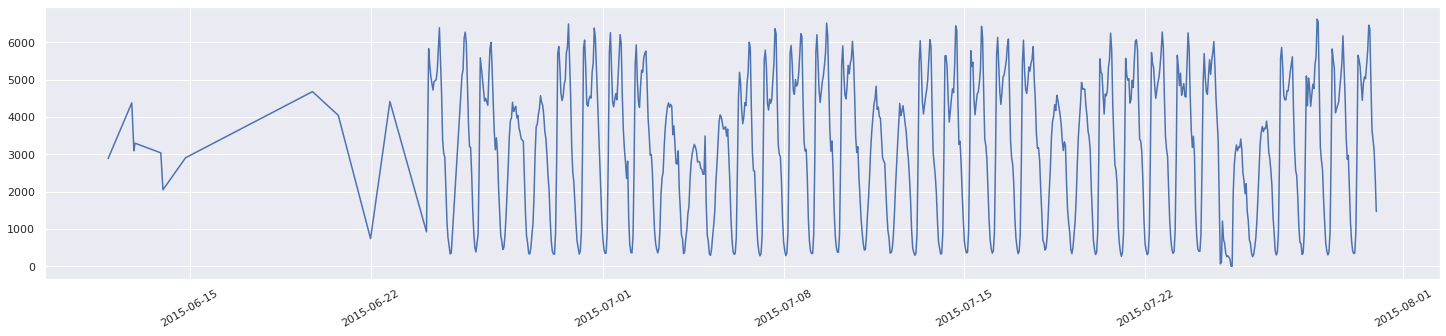

In [41]:
plt.figure(figsize=(25, 5))
plt.plot(df_reduced.loc['2015-06-11':'2015-07-30', 'traffic_volume'])
plt.xticks(rotation=30);

In [42]:
df_reduced = df_reduced.loc['2015-07':]
df_reduced.head()

,weather_main,traffic_volume
date_time,,
2015-07-01 00:00:00,Clear,737
2015-07-01 01:00:00,Clear,444
2015-07-01 02:00:00,Clear,347
2015-07-01 03:00:00,Rain,356
2015-07-01 04:00:00,Clear,936


We can consider data starting __from July 2015__ because of big gap in data. Still we have quite __long history - over 3 years__.
* check if there are missing indexes
* check if there are duplicates indexes

In [43]:
# if there are missing indexes
df_reduced.index.isnull().sum()

0

## Task 4
* create transformer __CutDateTransformer__ which takes dataset from specified date, e.g., 2015-07-01
* extend the pipeline from Task 5

In [44]:
class CutDateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, start_date):
        self.start_date = start_date
        
    def fit(self, X, y=None):   
        return self 
    
    def transform(self, X, y=None):
        X = X.sort_index()
        return X.loc[self.start_date:]

In [45]:
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('weather_transformer', WeatherTransformer(categories=['Clear', 'Clouds', 'Mist', 'Rain']))
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description'])),
                ('weather_transformer',
                 WeatherTransformer(categories=['Clear', 'Clouds', 'Mist',
                                                'Rain']))])

In [46]:
df_reduced = pipeline.transform(raw_df)
df_reduced.head()

,weather_main,traffic_volume
date_time,,
2015-07-01 00:00:00,Clear,737
2015-07-01 01:00:00,Clear,444
2015-07-01 02:00:00,Clear,347
2015-07-01 03:00:00,Rain,356
2015-07-01 04:00:00,Clear,936


## Duplicates

In [47]:
# duplicated
df_reduced.index.duplicated().sum()

5519

In [48]:
df_reduced[df_reduced.index.duplicated()].head()

,weather_main,traffic_volume
date_time,,
2015-07-04 01:00:00,Mist,851
2015-07-04 02:00:00,Mist,735
2015-07-04 02:00:00,Other,735
2015-07-04 03:00:00,Mist,341
2015-07-04 03:00:00,Other,341


In [49]:
df_reduced.loc['2015-07-04':'2015-07-05'].head(8)

,weather_main,traffic_volume
date_time,,
2015-07-04 00:00:00,Other,1512
2015-07-04 01:00:00,Other,851
2015-07-04 01:00:00,Mist,851
2015-07-04 02:00:00,Other,735
2015-07-04 02:00:00,Mist,735
2015-07-04 02:00:00,Other,735
2015-07-04 03:00:00,Other,341
2015-07-04 03:00:00,Mist,341


### Duplicates: volume traffic is the same but the weather changed. Duplicates can be removed.

In [50]:
# condition to filter out duplicated values
not_duplicated = ~df_reduced.index.duplicated()
df_no_duplicates = df_reduced.loc[not_duplicated]
df_no_duplicates.head()

,weather_main,traffic_volume
date_time,,
2015-07-01 00:00:00,Clear,737
2015-07-01 01:00:00,Clear,444
2015-07-01 02:00:00,Clear,347
2015-07-01 03:00:00,Rain,356
2015-07-01 04:00:00,Clear,936


In [51]:
df_no_duplicates.index.duplicated().sum()

0

In [52]:
df_no_duplicates.shape

(26528, 2)

## Task 5
* create transformer __RemoveDuplicatesTransformer__ to remove duplicated indexes
* extend the previous pipeline by this new transformer
* save result of transformation into __temp_df__

In [53]:
class RemoveDuplicatesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):   
        return self 
    
    def transform(self, X, y=None):
        not_duplicated = ~X.index.duplicated()
        return X.loc[not_duplicated]

In [54]:
# remove_duplicates should better go after cut_date transformer
# this might impact the distribution of weather categories - better to implement threshold version
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('weather_transformer', WeatherTransformer(categories=['Clear', 'Clouds', 'Mist', 'Rain'])),
    ('rd_transformer', RemoveDuplicatesTransformer())
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description'])),
                ('weather_transformer',
                 WeatherTransformer(categories=['Clear', 'Clouds', 'Mist',
                                                'Rain'])),
                ('rd_transformer', RemoveDuplicatesTransformer())])

In [55]:
temp_df = pipeline.transform(raw_df)
temp_df.head()

,weather_main,traffic_volume
date_time,,
2015-07-01 00:00:00,Clear,737
2015-07-01 01:00:00,Clear,444
2015-07-01 02:00:00,Clear,347
2015-07-01 03:00:00,Rain,356
2015-07-01 04:00:00,Clear,936


In [56]:
temp_df.index.duplicated().sum()

0

# Missing values

## Missing indexes 

<br>
E.g., 01-01, 01-02, 01-04, 01-05 => here 01-03 is missing index

In [57]:
# all the time steps from min to max date within our dataset with specified frequency
full_idx = pd.date_range(start=temp_df.index.min(), end=temp_df.index.max(), freq='1H')
print(full_idx[:5])

DatetimeIndex(['2015-07-01 00:00:00', '2015-07-01 01:00:00',
               '2015-07-01 02:00:00', '2015-07-01 03:00:00',
               '2015-07-01 04:00:00'],
              dtype='datetime64[ns]', freq='H')


In [58]:
len(full_idx), temp_df.shape[0], len(full_idx) - temp_df.shape[0]

(28512, 26528, 1984)

In [59]:
# missing indexes - those which present in full_idx but absent in the dataset
missing_indexes = ~full_idx.isin(temp_df.index) # True if missing otherwise False
missing_indexes

array([False, False, False, ..., False, False, False])

In [60]:
print(f'Number of missing values/indexes: {np.sum(missing_indexes)}') 
print(f'Pecentage form entire dataset: {np.mean(missing_indexes)}')

Number of missing values/indexes: 1984
Pecentage form entire dataset: 0.06958473625140292


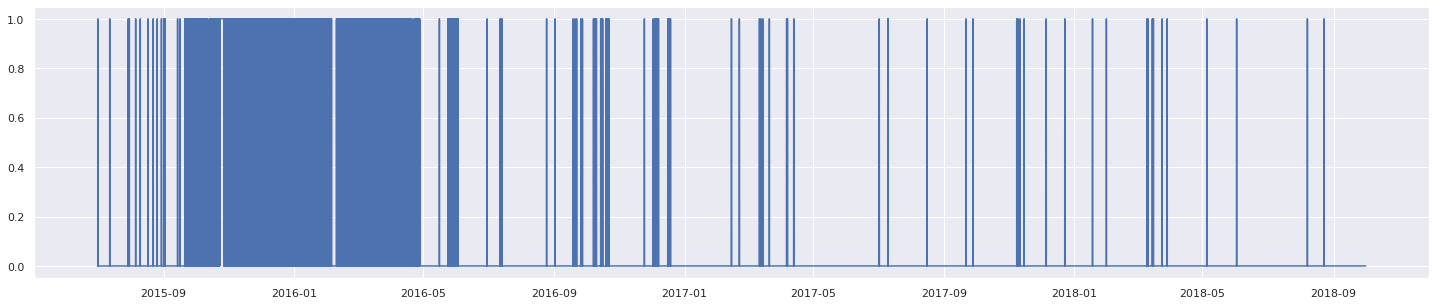

In [61]:
missing_indexes_df = pd.Series(missing_indexes, index=full_idx) # True (1) if missing or False (0) if present
plt.figure(figsize=(25, 5))
plt.plot(missing_indexes_df);

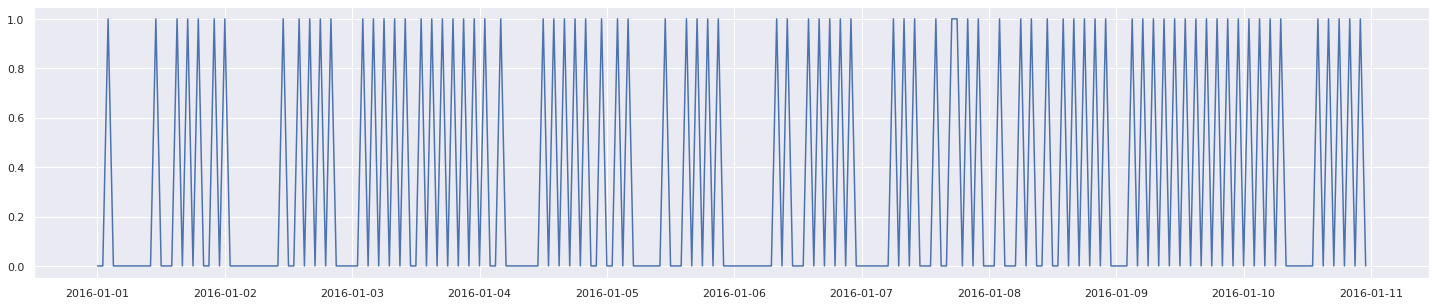

In [62]:
plt.figure(figsize=(25, 5))
plt.plot(missing_indexes_df.loc['2016-01-01':'2016-01-10']);

## Resample Data

### Hourly
We are interested in daily values. But before this, we need to fill missing hourly values otherwise during the aggregation (especially sum) the daily value will be significantly underestimated. 


In [63]:
temp_df.head()

,weather_main,traffic_volume
date_time,,
2015-07-01 00:00:00,Clear,737
2015-07-01 01:00:00,Clear,444
2015-07-01 02:00:00,Clear,347
2015-07-01 03:00:00,Rain,356
2015-07-01 04:00:00,Clear,936


In [64]:
temp_df.index = pd.to_datetime(temp_df.index)

In [65]:
df_res_H = pd.DataFrame()

# interpolate missing values ('mean' between missing values)
df_res_H['traffic_volume'] = temp_df['traffic_volume'].resample('1H').mean().interpolate()

# impute by fill forward (value from the nearest past)
df_res_H['weather_main'] = temp_df['weather_main'].resample('1H').ffill()

In [66]:
df_res_H.head()

,traffic_volume,weather_main
date_time,,
2015-07-01 00:00:00,737.0,Clear
2015-07-01 01:00:00,444.0,Clear
2015-07-01 02:00:00,347.0,Clear
2015-07-01 03:00:00,356.0,Rain
2015-07-01 04:00:00,936.0,Clear


In [67]:
print(pd.infer_freq(df_res_H.index))  # dane są próbkowane co godzinę dla całego szeregu czasowego

H


### Task 6
* create transformer __HourlyResampleTransformer__ for hourly resampling the dataset
* extend the previous pipeline
* check if the transformed dataset has H frequency

In [68]:
# instead of just interpolating using neighbouring points, we can consider wider context
# e.g., use smoothing with 3-5 points before or after the missing value
class HourlyResampleTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):   
        return self 
    
    def transform(self, X, y=None):
        
        df_res_H = pd.DataFrame()
        df_res_H['traffic_volume'] = X['traffic_volume'].resample('1H').mean().interpolate()  # interpolate missing values
        df_res_H['weather_main'] = X['weather_main'].resample('1H').ffill()  # impute by fill forward
        
        return df_res_H

In [69]:
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('weather_transformer', WeatherTransformer(categories=['Clear', 'Clouds', 'Mist', 'Rain'])),
    ('rd_transformer', RemoveDuplicatesTransformer()),
    ('hr_transformer', HourlyResampleTransformer()) 
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description'])),
                ('weather_transformer',
                 WeatherTransformer(categories=['Clear', 'Clouds', 'Mist',
                                                'Rain'])),
                ('rd_transformer', RemoveDuplicatesTransformer()),
                ('hr_transformer', HourlyResampleTransformer())])

In [70]:
df_res_H = pipeline.transform(raw_df)
df_res_H.head()

,traffic_volume,weather_main
date_time,,
2015-07-01 00:00:00,737.0,Clear
2015-07-01 01:00:00,444.0,Clear
2015-07-01 02:00:00,347.0,Clear
2015-07-01 03:00:00,356.0,Rain
2015-07-01 04:00:00,936.0,Clear


In [71]:
print(pd.infer_freq(df_res_H.index))

H


### Daily
During the downsampling process (from Hourlly to Daily) the aggregation method should be selected for each column:
* traffic volume - sum during the day
* weather - the most often during the day

In [72]:
from statistics import mode

In [73]:
mode(['1', '1', 2])

'1'

In [74]:
df_res_H.loc['2015-09-01']['weather_main'].value_counts()

weather_main
Other    12
Rain      6
Clear     5
Mist      1
Name: count, dtype: int64

In [75]:
df_res_D = pd.DataFrame()

df_res_D['traffic_volume'] = df_res_H['traffic_volume'].resample('1D').sum()
df_res_D['weather_main'] = df_res_H['weather_main'].resample('1D').apply(lambda x: mode(x))

In [76]:
df_res_D.head()

,traffic_volume,weather_main
date_time,,
2015-07-01,87440.0,Clear
2015-07-02,86035.0,Clear
2015-07-03,64366.0,Clear
2015-07-04,51400.0,Other
2015-07-05,56563.0,Clear


In [77]:
print(pd.infer_freq(df_res_D.index))

D


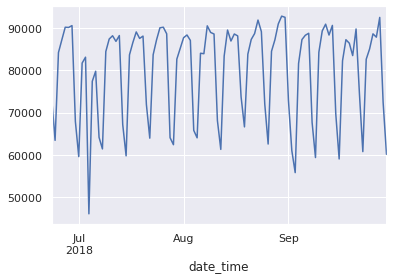

In [78]:
df_res_D['traffic_volume'][-100:].plot();  # bardzo mała wartość dla 4 lipca (święto w USA)

### Task 7
* create transformer __DailyResampleTransformer__ for daily resampling the dataset
* extend the previous pipeline
* check if the transformed dataset has D frequency

In [79]:
class DailyResampleTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):   
        return self 
    
    def transform(self, X, y=None):
        
        df_res_D = pd.DataFrame()
        df_res_D['traffic_volume'] = X['traffic_volume'].resample('1D').sum()
        df_res_D['weather_main'] = X['weather_main'].resample('1D').apply(lambda x: mode(x))
        
        return df_res_D

In [80]:
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('weather_transformer', WeatherTransformer(categories=['Clear', 'Clouds', 'Mist', 'Rain'])),
    ('rd_transformer', RemoveDuplicatesTransformer()),
    ('hr_transformer', HourlyResampleTransformer()) ,
    ('dr_transformer', DailyResampleTransformer())
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description'])),
                ('weather_transformer',
                 WeatherTransformer(categories=['Clear', 'Clouds', 'Mist',
                                                'Rain'])),
                ('rd_transformer', RemoveDuplicatesTransformer()),
                ('hr_transformer', HourlyResampleTransformer()),
                ('dr_transformer', DailyResampleTransformer())])

In [81]:
transformed_df = pipeline.transform(raw_df)
transformed_df.head()

,traffic_volume,weather_main
date_time,,
2015-07-01,87440.0,Clear
2015-07-02,86035.0,Clear
2015-07-03,64366.0,Clear
2015-07-04,51400.0,Other
2015-07-05,56563.0,Clear


In [82]:
print(pd.infer_freq(transformed_df.index))

D


## Outliers
We want to cut upper 0.5% of values as well as lower 0.5% of values to get rid of suspicious values.

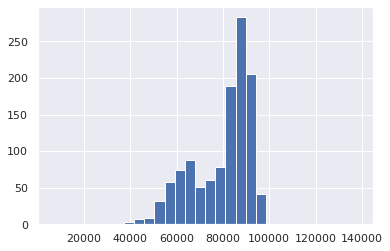

41187 97374


In [83]:
y = transformed_df['traffic_volume']
y.hist(bins=30)
plt.show()

low, high = round(np.percentile(y, 0.5)), round(np.percentile(y, 99.5))
print(low, high)

In [84]:
low_99, high_99 = round(np.percentile(y, 1)), round(np.percentile(y, 99))
print(low_99, high_99)

45279 96861


In [85]:
def f(low, high, x):
    
    if x < low:
        x = low
    elif x > high:
        x = high
    
    return x

y_no_outliers = y.copy()
y_no_outliers = y_no_outliers.apply(lambda x: f(low, high, x))

print((y != y_no_outliers).sum())

12


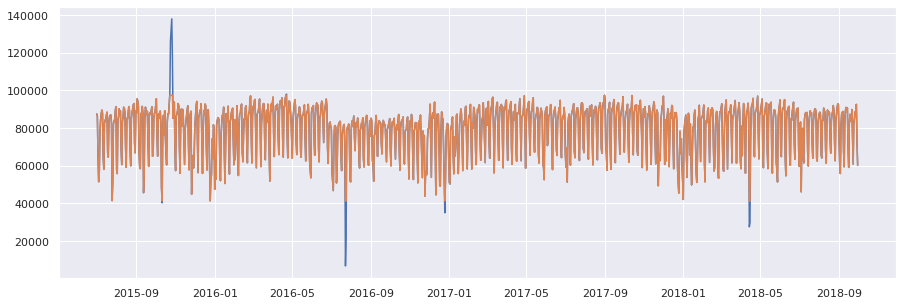

In [86]:
plt.figure(figsize=(15, 5))

plt.plot(y)
plt.plot(y_no_outliers)

plt.show()

## Task 8
* implement transformer __VolumeRemoveOutliersTransformer__ with passing percentiles like [1, 99]
* extend the previous pipeline

In [87]:
class VolumeRemoveOutliersTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, percentiles=[1, 99], col='traffic_volume'):
        
        self.percentiles = percentiles
        self.boundaries = [0, 0]
        self.col = col
        
    def fit(self, X, y=None):
        
        self.boundaries[0] = round(np.percentile(X[self.col], self.percentiles[0]))
        self.boundaries[1] = round(np.percentile(X[self.col], self.percentiles[1]))
        
        return self
    
    def transform(self, X, y=None):
        
        def f(low, high, x):
            if x < low:
                x = low
            elif x > high:
                x = high
            return x
    
        X[self.col] = X[self.col].apply(lambda x: f(self.boundaries[0], self.boundaries[1], x))
        
        return X

In [88]:
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('weather_transformer', WeatherTransformer(categories=['Clear', 'Clouds', 'Mist', 'Rain'])),
    ('rd_transformer', RemoveDuplicatesTransformer()),
    ('hr_transformer', HourlyResampleTransformer()),
    ('dr_transformer', DailyResampleTransformer()),
    ('vro_transformer', VolumeRemoveOutliersTransformer(percentiles=[1, 99]))
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description'])),
                ('weather_transformer',
                 WeatherTransformer(categories=['Clear', 'Clouds', 'Mist',
                                                'Rain'])),
                ('rd_transformer', RemoveDuplicatesTransformer()),
                ('hr_transformer', HourlyResampleTransformer()),
                ('dr_transformer', DailyResampleTransformer()),
                ('vro_transformer', VolumeRemoveOutliersTransformer())])

In [89]:
transformed_df = pipeline.transform(raw_df)
transformed_df.head()

,traffic_volume,weather_main
date_time,,
2015-07-01,87440.0,Clear
2015-07-02,86035.0,Clear
2015-07-03,64366.0,Clear
2015-07-04,51400.0,Other
2015-07-05,56563.0,Clear


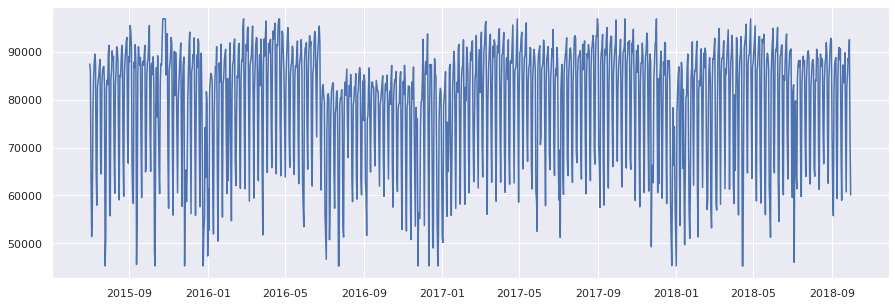

In [90]:
plt.figure(figsize=(15, 5))
plt.plot(transformed_df['traffic_volume']);

# Features Engineering
1. date related features
    - month
    - day of month
    - day of week
    - is a day a weekend?
    - is a day a holiday? (we have it already)
    - is it a beginning/end of the month?
    - is it a beginning/end of the quarter?
2. trend & seasonality
3. differencing
4. percentage change
5. rolling statistics for above mentioned
    - moving average for last 3,5,7,14 days
    - moving standard deviation/max/median for 3/5/7/14/... days
6. lagged values for above mentioned
    - lagged values of volume traffic with lag of 3/5/7/14/... days
    - lagged values of rolling statistics with lag of 3/5/7/14/... days
7. differencing of rolling statistics and lagged values 
etc.
    

### Date-related features

In [91]:
transformed_df.head()

,traffic_volume,weather_main
date_time,,
2015-07-01,87440.0,Clear
2015-07-02,86035.0,Clear
2015-07-03,64366.0,Clear
2015-07-04,51400.0,Other
2015-07-05,56563.0,Clear


In [92]:
def generate_date_features(df_features):
    
    df_features['date'] = pd.to_datetime(df_features.index)  # kolumna pomocnicza, ułatwia tworzenie innych kolumn
    df_features['month'] = df_features['date'].dt.month
    df_features['month_day'] = df_features['date'].dt.day
    df_features['day_of_week'] = df_features['date'].dt.dayofweek # 0 - Monday; 6 - Sunday
    df_features['is_weekend'] = np.where(df_features['day_of_week'].isin([5, 6]), 1, 0)
    
    return df_features

In [93]:
df_features = generate_date_features(transformed_df)
df_features.head()

,traffic_volume,weather_main,date,month,month_day,day_of_week,is_weekend
date_time,,,,,,,
2015-07-01,87440.0,Clear,2015-07-01,7,1,2,0
2015-07-02,86035.0,Clear,2015-07-02,7,2,3,0
2015-07-03,64366.0,Clear,2015-07-03,7,3,4,0
2015-07-04,51400.0,Other,2015-07-04,7,4,5,1
2015-07-05,56563.0,Clear,2015-07-05,7,5,6,1


In [94]:
df_features.groupby('day_of_week').agg({'traffic_volume': 'mean'})

,traffic_volume
day_of_week,
0,79924.671006
1,85311.441420
2,86576.020588
3,88250.860294
4,88373.062395
5,68758.933389
6,59688.529216


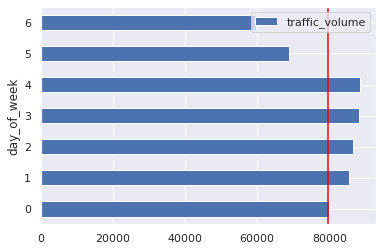

In [95]:
# depending on the day of week
df_features.groupby('day_of_week').agg({'traffic_volume': 'mean'}).plot.barh()

plt.vlines(df_features['traffic_volume'].mean(), ymin=-1, ymax=7, color='red')
plt.show()

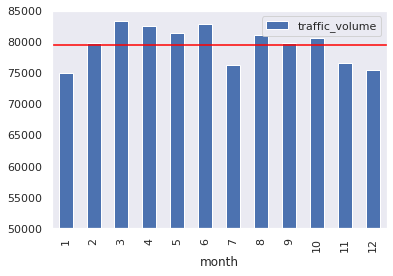

In [96]:
# depending on the month
df_features.groupby('month').agg({'traffic_volume': 'mean'}).plot.bar()

plt.hlines(df_features['traffic_volume'].mean(), xmin=-1, xmax=12, color='red')
plt.ylim(50000, 85000)
plt.grid()

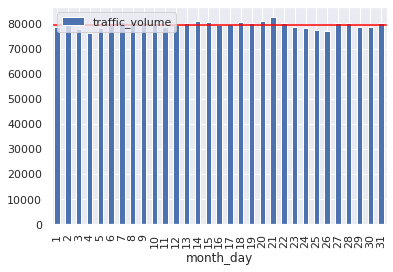

In [97]:
# depending on the day of month
df_features.groupby('month_day').agg({'traffic_volume': 'mean'}).plot.bar()

plt.hlines(df_features['traffic_volume'].mean(), xmin=-1, xmax=32, color='red')
plt.show()

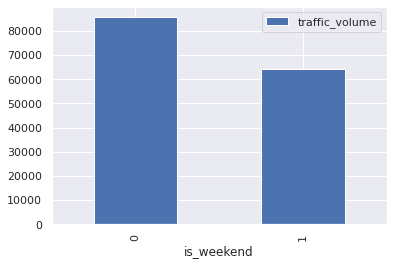

In [98]:
df_features.groupby('is_weekend').agg({'traffic_volume': 'mean'}).plot.bar()
plt.show()

### Conclusion for date-related features:
* feature __'month_day'__ doesn't show any impact on the traffic volume so we may remove them.
* other features should be kept.

### Trend and Seasonality

In [99]:
series = df_features['traffic_volume']

In [100]:
result = seasonal_decompose(series)
df_features['seasonality'] = result.seasonal
df_features['trend'] = result.trend

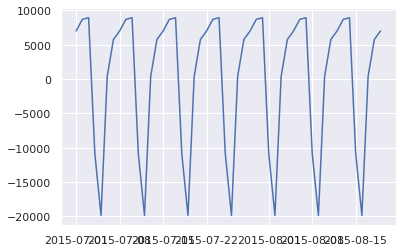

In [101]:
plt.plot(df_features['seasonality'][:50])
plt.show()

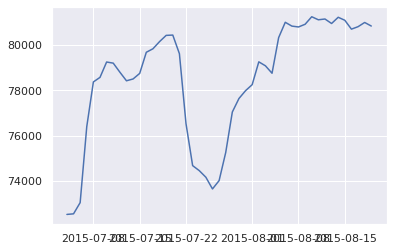

In [102]:
plt.plot(df_features['trend'][:50])
plt.show()

### Rolling statistics

In [103]:
for i in range(2, 8): # from 2 to 7
    df_features[f'mov_avg_{i}'] = df_features['traffic_volume'].rolling(window=i).mean()
    df_features[f'mov_std_{i}'] = df_features['traffic_volume'].rolling(window=i).std()
    
df_features.head()

,traffic_volume,weather_main,date,month,month_day,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_avg_3,mov_std_3,mov_avg_4,mov_std_4,mov_avg_5,mov_std_5,mov_avg_6,mov_std_6,mov_avg_7,mov_std_7
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,Clear,2015-07-01,7,1,2,0,6980.597411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,86035.0,Clear,2015-07-02,7,2,3,0,8670.668628,NaN,86737.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,64366.0,Clear,2015-07-03,7,3,4,0,8903.999854,NaN,75200.5,...,79280.333333,12935.281610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-04,51400.0,Other,2015-07-04,7,4,5,1,-10808.961986,72533.285714,57883.0,...,67267.000000,17498.790158,72310.25,17489.308741,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-05,56563.0,Clear,2015-07-05,7,5,6,1,-19861.135246,72559.000000,53981.5,...,57443.000000,6527.640385,64591.00,15257.206232,69160.8,16703.35645,NaN,NaN,NaN,NaN


In [104]:
df_features.shape

(1188, 21)

### Lagged Values

In [105]:
for i in range(1, 8): # from 1 to 7
    df_features[f'traffic_lag_{i}'] = df_features['traffic_volume'].shift(i)
    
df_features.head()

,traffic_volume,weather_main,date,month,month_day,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_std_6,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,Clear,2015-07-01,7,1,2,0,6980.597411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,86035.0,Clear,2015-07-02,7,2,3,0,8670.668628,NaN,86737.5,...,NaN,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,64366.0,Clear,2015-07-03,7,3,4,0,8903.999854,NaN,75200.5,...,NaN,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN
2015-07-04,51400.0,Other,2015-07-04,7,4,5,1,-10808.961986,72533.285714,57883.0,...,NaN,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN
2015-07-05,56563.0,Clear,2015-07-05,7,5,6,1,-19861.135246,72559.000000,53981.5,...,NaN,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN


In [106]:
df_features.shape

(1188, 28)

### Categorical Column - __weather_main__


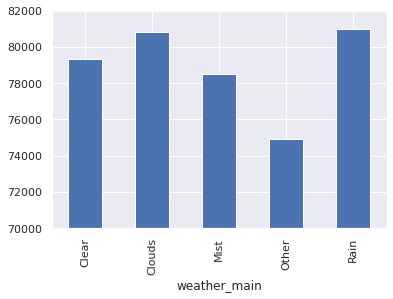

In [107]:
df_features.groupby('weather_main').mean()['traffic_volume'].plot.bar()
plt.ylim(70000, 82000)
plt.show()

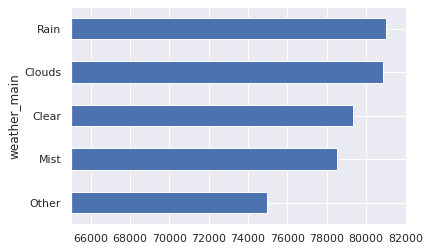

In [108]:
df_features.groupby('weather_main').mean()['traffic_volume'].sort_values().plot.barh()
plt.xlim(65000, 82000)
plt.show()

### Two ways of encoding:
* ___One Hot Encoding___
* ___Ordinal Encoding___ with taking into consideration the correlation with the target

The second option gives only one additional dimension instead of 5 for ___OHE___.
Mapping will be like this: 
* Rain - 1
* Clouds - 2
* Clear - 3
* Mist - 4
* Other - 5

In [109]:
def map_weather(weather):
    d = {'Rain': 1, 
        'Clouds': 2, 
        'Clear': 3, 
        'Mist': 4, 
        'Other': 5}
    return d[weather]
    
df_features['weather'] = df_features['weather_main'].apply(lambda x: map_weather(x))

In [110]:
df_features[['weather', 'weather_main']].head()

,weather,weather_main
date_time,,
2015-07-01,3,Clear
2015-07-02,3,Clear
2015-07-03,3,Clear
2015-07-04,5,Other
2015-07-05,3,Clear


In [111]:
df_features.head()

,traffic_volume,weather_main,date,month,month_day,day_of_week,is_weekend,seasonality,trend,mov_avg_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,Clear,2015-07-01,7,1,2,0,6980.597411,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-02,86035.0,Clear,2015-07-02,7,2,3,0,8670.668628,NaN,86737.5,...,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-03,64366.0,Clear,2015-07-03,7,3,4,0,8903.999854,NaN,75200.5,...,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN,3
2015-07-04,51400.0,Other,2015-07-04,7,4,5,1,-10808.961986,72533.285714,57883.0,...,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN,5
2015-07-05,56563.0,Clear,2015-07-05,7,5,6,1,-19861.135246,72559.000000,53981.5,...,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN,3


In [112]:
df_features = df_features.drop('weather_main', axis=1)
df_features.head()

,traffic_volume,date,month,month_day,day_of_week,is_weekend,seasonality,trend,mov_avg_2,mov_std_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-01,87440.0,2015-07-01,7,1,2,0,6980.597411,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-02,86035.0,2015-07-02,7,2,3,0,8670.668628,NaN,86737.5,993.485028,...,NaN,NaN,87440.0,NaN,NaN,NaN,NaN,NaN,NaN,3
2015-07-03,64366.0,2015-07-03,7,3,4,0,8903.999854,NaN,75200.5,15322.296842,...,NaN,NaN,86035.0,87440.0,NaN,NaN,NaN,NaN,NaN,3
2015-07-04,51400.0,2015-07-04,7,4,5,1,-10808.961986,72533.285714,57883.0,9168.346525,...,NaN,NaN,64366.0,86035.0,87440.0,NaN,NaN,NaN,NaN,5
2015-07-05,56563.0,2015-07-05,7,5,6,1,-19861.135246,72559.000000,53981.5,3650.792311,...,NaN,NaN,51400.0,64366.0,86035.0,87440.0,NaN,NaN,NaN,3


In [113]:
df_features.isna().sum()

traffic_volume    0
date              0
month             0
month_day         0
day_of_week       0
is_weekend        0
seasonality       0
trend             6
mov_avg_2         1
mov_std_2         1
mov_avg_3         2
mov_std_3         2
mov_avg_4         3
mov_std_4         3
mov_avg_5         4
mov_std_5         4
mov_avg_6         5
mov_std_6         5
mov_avg_7         6
mov_std_7         6
traffic_lag_1     1
traffic_lag_2     2
traffic_lag_3     3
traffic_lag_4     4
traffic_lag_5     5
traffic_lag_6     6
traffic_lag_7     7
weather           0
dtype: int64

In [114]:
df_features.shape

(1188, 28)

In [115]:
df_features_na = df_features.ffill()  # dodatkowe zabezpieczenie dla wartości NaN w środku szeregu
df_features_na = df_features_na.dropna()
df_features_na.head()

,traffic_volume,date,month,month_day,day_of_week,is_weekend,seasonality,trend,mov_avg_2,mov_std_2,...,mov_avg_7,mov_std_7,traffic_lag_1,traffic_lag_2,traffic_lag_3,traffic_lag_4,traffic_lag_5,traffic_lag_6,traffic_lag_7,weather
date_time,,,,,,,,,,,,,,,,,,,,,
2015-07-08,87620.0,2015-07-08,7,8,2,0,6980.597411,78370.142857,85943.0,2371.636144,...,72559.000000,14956.835160,84266.0,77663.0,56563.0,51400.0,64366.0,86035.0,87440.0,3
2015-07-09,89488.0,2015-07-09,7,9,3,0,8670.668628,78571.000000,88554.0,1320.875467,...,73052.285714,15521.633599,87620.0,84266.0,77663.0,56563.0,51400.0,64366.0,86035.0,3
2015-07-10,87818.0,2015-07-10,7,10,4,0,8903.999854,79247.285714,88653.0,1180.868325,...,76402.571429,15861.538995,89488.0,87620.0,84266.0,77663.0,56563.0,51400.0,64366.0,3
2015-07-11,65173.0,2015-07-11,7,11,5,1,-10808.961986,79197.857143,76495.5,16012.433060,...,78370.142857,12802.381620,87818.0,89488.0,87620.0,84266.0,77663.0,56563.0,51400.0,2
2015-07-12,57969.0,2015-07-12,7,12,6,1,-19861.135246,78801.000000,61571.0,5093.997252,...,78571.000000,12408.186787,65173.0,87818.0,89488.0,87620.0,84266.0,77663.0,56563.0,2


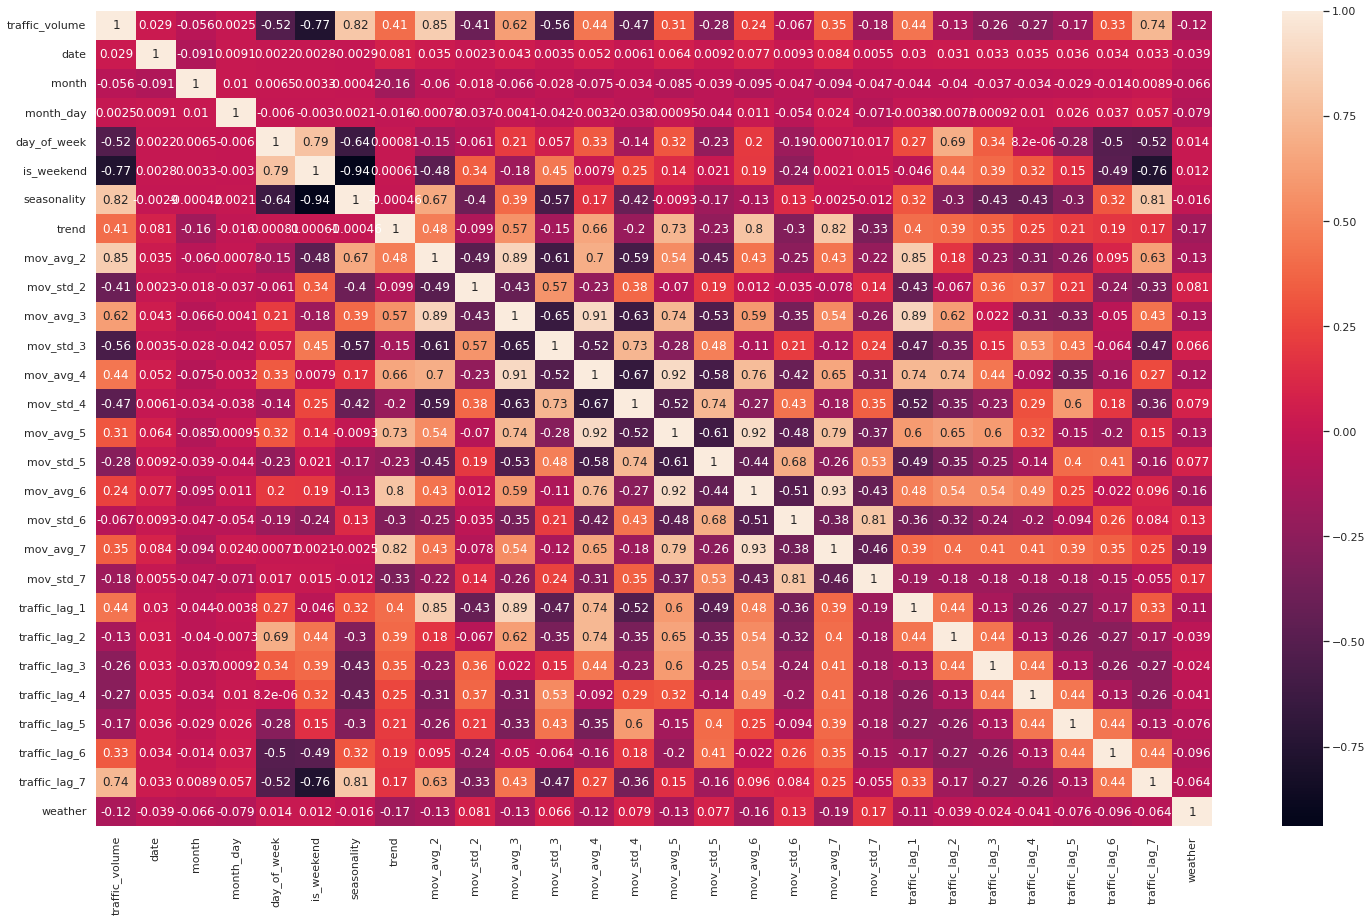

In [116]:
plt.figure(figsize=(25, 15))
sns.heatmap(df_features_na.corr(), annot=True)
plt.show()

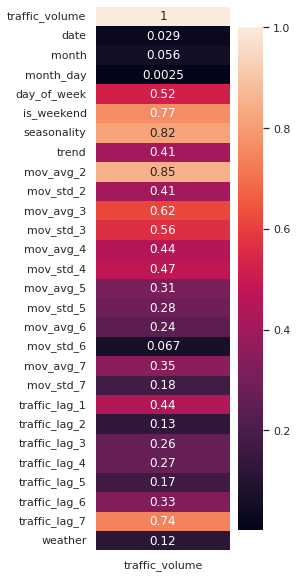

In [117]:
plt.figure(figsize=(3, 10))

# sns.heatmap(pd.DataFrame(df_features_na.corr()['traffic_volume']), annot=True)
sns.heatmap(pd.DataFrame(np.abs(df_features_na.corr())['traffic_volume']), annot=True)

plt.show()

**weather is not important even although we spent so much time :D**

In [118]:
a = df_features_na.corr()['traffic_volume']
print(a[a > 0.5].index.tolist())
print(a[a < -0.5].index.tolist())

['traffic_volume', 'seasonality', 'mov_avg_2', 'mov_avg_3', 'traffic_lag_7']
['day_of_week', 'is_weekend', 'mov_std_3']


## Task 9
* implement __FeatureEngineeringTransformer__ which computes following features with correlation absolute value higher than __0.5__
* remove additionally columns which are not correlated: e.g., weather
* extend the pipeline

In [119]:
print(a[np.abs(a) > 0.5].index.tolist()[1:])

['day_of_week', 'is_weekend', 'seasonality', 'mov_avg_2', 'mov_avg_3', 'mov_std_3', 'traffic_lag_7']


__better solution - create transformer for all the features__:
then create another transformer for features selection based on the correlation coeffcient

In [120]:
# more general version with controlled correlation threshold
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, corr=0.5):
        self.corr = corr
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X = pd.DataFrame(X)
        
        X['date'] = pd.to_datetime(X.index)
        X['month'] = X['date'].dt.month
        X['month_day'] = X['date'].dt.day
        X['day_of_week'] = X['date'].dt.dayofweek # 0 - Monday; 6 - Sunday
        X['is_weekend'] = np.where(X['day_of_week'].isin([5, 6]), 1, 0)
         
        series = seasonal_decompose(X['traffic_volume'])
        X['seasonality'] = series.seasonal
        X['trend'] = series.trend
        
        for i in range(2, 8): # from 2 to 7
            X[f'mov_avg_{i}'] = X['traffic_volume'].rolling(window=i).mean()
            X[f'mov_std_{i}'] = X['traffic_volume'].rolling(window=i).std()
            
        for i in range(1, 8): # from 1 to 7
            X[f'traffic_lag_{i}'] = X['traffic_volume'].shift(i)
            
        def map_weather(weather):
            d = {'Rain': 1, 'Clouds': 2, 'Clear': 3, 'Mist': 4, 'Other': 5}
            return d[weather]
    
        X['weather'] = X['weather_main'].apply(lambda x: map_weather(x))
        X = X.drop('weather_main', axis=1)
            
        X = X.ffill().dropna()
        
        imp = X.corr()['traffic_volume']
        features = imp[np.abs(imp) > self.corr].index.tolist()

        return X[features]

In [121]:
pipeline = Pipeline(steps=[
    ('ts_transformer', MakeTSTransformer(index_column='date_time')),
    ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
    ('col_remover', RemoveColumnsTransformer(
        columns_to_remove=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_description'])),
    ('weather_transformer', WeatherTransformer(categories=['Clear', 'Clouds', 'Mist', 'Rain'])),
    ('rd_transformer', RemoveDuplicatesTransformer()),
    ('hr_transformer', HourlyResampleTransformer()),
    ('dr_transformer', DailyResampleTransformer()),
    ('features_transformer', FeatureEngineeringTransformer(corr=0.5))
])

pipeline.fit(raw_df)

Pipeline(steps=[('ts_transformer', MakeTSTransformer()),
                ('cd_transformer', CutDateTransformer(start_date='2015-07-01')),
                ('col_remover',
                 RemoveColumnsTransformer(columns_to_remove=['temp', 'rain_1h',
                                                             'snow_1h',
                                                             'clouds_all',
                                                             'weather_description'])),
                ('weather_transformer',
                 WeatherTransformer(categories=['Clear', 'Clouds', 'Mist',
                                                'Rain'])),
                ('rd_transformer', RemoveDuplicatesTransformer()),
                ('hr_transformer', HourlyResampleTransformer()),
                ('dr_transformer', DailyResampleTransformer()),
                ('features_transformer', FeatureEngineeringTransformer())])

# Models Training


In [122]:
raw_df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2015-06-11 20:00:00,287.586,0.0,0.0,92,Rain,light rain,2886
1,2015-06-12 18:00:00,297.543,0.0,0.0,0,Clear,Sky is Clear,4380
2,2015-06-12 20:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3095
3,2015-06-12 21:00:00,292.061,0.0,0.0,8,Clear,sky is clear,3299
4,2015-06-13 21:00:00,294.840,0.0,0.0,76,Clouds,broken clouds,3040


In [123]:
df_final = pipeline.transform(raw_df)
df_final.head()

,traffic_volume,day_of_week,is_weekend,seasonality,mov_avg_2,mov_avg_3,mov_std_3,traffic_lag_7
date_time,,,,,,,,
2015-07-08,87620.0,2,0,6974.791175,85943.0,83183.000000,5066.076292,87440.0
2015-07-09,89488.0,3,0,8656.829848,88554.0,87124.666667,2646.004031,86035.0
2015-07-10,87818.0,4,0,8893.785446,88653.0,88308.666667,1026.119551,64366.0
2015-07-11,65173.0,5,1,-10997.842091,76495.5,80826.333333,13581.876098,51400.0
2015-07-12,57969.0,6,1,-19983.312927,61571.0,70320.000000,15575.923953,56563.0


In [124]:
X = df_final.drop('traffic_volume', axis=1)
y = df_final['traffic_volume']

In [125]:
X.shape

(1181, 7)

In [126]:
# example metrics: MSE, MAE, mAE, MAPE, ...
def mse(y_pred, y_true):
    return round(np.sqrt(mean_squared_error(y_pred, y_true)))

### Train-Test Split

In [127]:
# 20% for validation
split_index = int(y.shape[0] * 0.8)
split_index

944

In [128]:
y_train, y_test = y[:split_index], y[split_index:]

## Naive Forecast

In [129]:
def naive_forecast(ts, period):
    
    actual = ts[period:]
    preds = ts.shift(period)[period:]
    
    return mse(actual, preds)

In [130]:
naive_forecast(y_test, period=7)

9938

### Baseline Performance

In [131]:
naive_mse = []

for i in range(1, 8):
    
    error = naive_forecast(y_test, period=i)
    naive_mse.append(error)
    
    print(f'{i}: {error}')

1: 14171
2: 20421
3: 21533
4: 21637
5: 20745
6: 15621
7: 9938


__For ML model to be useful, it should have better performance than _Naive Forecast_.__

## Data Preparation

In [132]:
X.head(2)

,day_of_week,is_weekend,seasonality,mov_avg_2,mov_avg_3,mov_std_3,traffic_lag_7
date_time,,,,,,,
2015-07-08,2,0,6974.791175,85943.0,83183.000000,5066.076292,87440.0
2015-07-09,3,0,8656.829848,88554.0,87124.666667,2646.004031,86035.0


In [133]:
y.head(2)

date_time
2015-07-08    87620.0
2015-07-09    89488.0
Freq: D, Name: traffic_volume, dtype: float64

In [134]:
def prepare_data(X, y, period, split_ratio=0.8):
    # define index border between train and test
    split_index = int(split_ratio * X.shape[0])
    
    # shift the features; remove missing values by slicing; target should be aligned with features
    X_shift = X.shift(period)[period:]
    y_shift = y[period:]
    
    # split original features and target on index
    X_train, X_test = X_shift[:split_index], X_shift[split_index:]
    y_train, y_test = y_shift[:split_index], y_shift[split_index:]
    
    return X_train, y_train, X_test, y_test

In [135]:
X = df_final.drop('traffic_volume', axis=1)
y = df_final['traffic_volume']

## Linear models
Assumptions:
* data are scaled
* data are normally distribited
* data are not multicolinear
* no outliers

### Ridge Regression

In [136]:
# pipeline definition
steps = [
    ('transform', PowerTransformer(method='yeo-johnson')), 
    ('scale', MinMaxScaler()), 
    ('pca', PCA(n_components=0.9)), # to remove highly correlated features
    ('ridge', Ridge())
]

pipeline = Pipeline(steps=steps)

In [137]:
ridge_preds = []
scores = []

for period in range(1, 8):
    
    X_train, y_train, X_test, y_test = prepare_data(X, y, period=period, split_ratio=0.8)

    params = {'ridge__alpha': [0, 0.01, 0.5, 0.9, 1.0]}
    cv = TimeSeriesSplit(n_splits=5).split(X_train)
    
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, verbose=0)
    grid_search.fit(X_train, y_train)
    
    ridge_model = grid_search.best_estimator_
    
    preds = ridge_model.predict(X_test)
    score = mse(preds, y_test)
    scores.append(score)
    
    pred = ridge_model.predict(X.tail(1))[0]
    ridge_preds.append(pred)
    
    print(f'Period: {period}')
    print(f'Forecast: {round(pred)} +/- {score}')
    
print(f"Average MSE: {round(np.mean(scores))}")

Period: 1
Forecast: 69547 +/- 10837
Period: 2
Forecast: 83140 +/- 9938
Period: 3
Forecast: 86883 +/- 10214
Period: 4
Forecast: 88204 +/- 11665
Period: 5
Forecast: 88151 +/- 8644
Period: 6
Forecast: 76730 +/- 9515
Period: 7
Forecast: 62539 +/- 7134
Average MSE: 9707


In [138]:
# błędy dla 'naive_forecast' są większe, więc stworzony model jest lepszy
naive_mse

[14171, 20421, 21533, 21637, 20745, 15621, 9938]

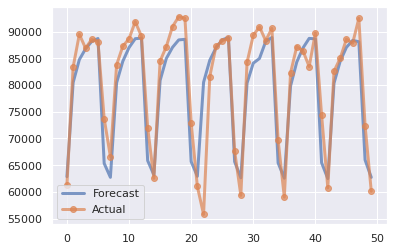

In [139]:
preds = ridge_model.predict(X_test)

plt.plot(preds[-50:], label='Forecast', linewidth=3, alpha=0.7)
plt.plot(y_test.values[-50:], 'o-', label='Actual', linewidth=3, alpha=0.7)
plt.legend();

## Task 10
* implement the training process and predictions using Lasso model

### Lasso

In [140]:
# pipeline definition
steps = [
    ('transform', PowerTransformer(method='yeo-johnson')), 
    ('scale', MinMaxScaler()), 
    ('lasso', Lasso())
]

pipeline = Pipeline(steps=steps)

In [141]:
lasso_preds = []
scores = []

for period in range(1, 8):
    
    X_train, y_train, X_test, y_test = prepare_data(X, y, period=period, split_ratio=0.8)

    params = {'lasso__alpha': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0]}
    cv = TimeSeriesSplit(n_splits=5).split(X_train)
    
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, verbose=0)
    grid_search.fit(X_train, y_train)
    
    lasso_model = grid_search.best_estimator_
    
    preds = lasso_model.predict(X_test)
    score = mse(preds, y_test)
    scores.append(score)
    
    pred = lasso_model.predict(X.tail(1))[0]
    lasso_preds.append(pred)
    
    print(f'Period: {period}')
    print(f'Forecast: {round(pred)} +/- {score}')
    
print(f"Average MSE: {round(np.mean(scores))}")

Period: 1
Forecast: 71994 +/- 10955
Period: 2
Forecast: 79956 +/- 9765
Period: 3
Forecast: 88672 +/- 9673
Period: 4
Forecast: 94204 +/- 10301
Period: 5
Forecast: 91061 +/- 8144
Period: 6
Forecast: 70421 +/- 7303
Period: 7
Forecast: 61202 +/- 7074
Average MSE: 9031


In [142]:
# błędy dla 'naive_forecast' są większe, więc stworzony model jest lepszy
naive_mse

[14171, 20421, 21533, 21637, 20745, 15621, 9938]

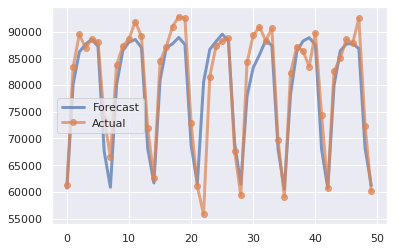

In [143]:
preds2 = lasso_model.predict(X_test)

plt.plot(preds2[-50:], label='Forecast', linewidth=3, alpha=0.7)
plt.plot(y_test.values[-50:], 'o-', label='Actual', linewidth=3, alpha=0.7)
plt.legend();

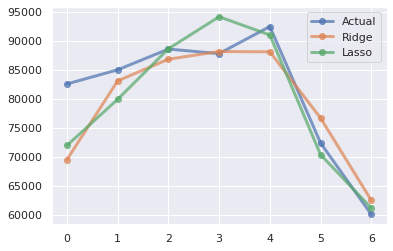

In [144]:
# comparison of both linear models with regularization
plt.plot(y_test.values[-7:], 'o-', label='Actual', linewidth=3, alpha=0.7)
plt.plot(ridge_preds, 'o-', label='Ridge', linewidth=3, alpha=0.7)
plt.plot(lasso_preds, 'o-', label='Lasso', linewidth=3, alpha=0.7)
plt.legend();

## Task 11 
* try non-linear model and compare the results (e.g., SVR, RandomForest)
* create function to facilitate this process (e.g., function which accepts algo object and params for grid search)

In [145]:
def try_algo(algo, params):
    
    steps = [
        ('transform', PowerTransformer(method='yeo-johnson')),
        ('scale', MinMaxScaler()),
        ('model', algo)
    ]
    
    pipeline = Pipeline(steps=steps)
    
    scores = []
    for period in range(1,8):
        
        X_train, y_train, X_test, y_test = prepare_data(X, y, period=period, split_ratio=0.8)
        cv = TimeSeriesSplit(n_splits=5).split(X_train)
        
        grid_search = GridSearchCV(pipeline, param_grid=params, cv=cv, verbose=0)
        grid_search.fit(X_train, y_train)
        
        model = grid_search.best_estimator_
        
        score = mse(model.predict(X_test), y_test)
        scores.append(score)
        
        pred = model.predict(X.tail(1))[0]
        
        print(f'Period: {period}')
        print(f'Forecast: {round(pred)} +/- {score}')
    
    print(f"Average MSE: {round(np.mean(scores))}")

In [146]:
# błąd porównywalny z algorytmami liniowymi
from sklearn.svm import SVR

params = {'model__C': [0.001, 0.01, 0.1, 1.0, 10]}
algo = SVR()

try_algo(algo, params)

Period: 1
Forecast: 82703 +/- 12951
Period: 2
Forecast: 83894 +/- 12822
Period: 3
Forecast: 84877 +/- 12841
Period: 4
Forecast: 85307 +/- 12988
Period: 5
Forecast: 85148 +/- 12612
Period: 6
Forecast: 82836 +/- 12892
Period: 7
Forecast: 80183 +/- 11854
Average MSE: 12709


In [147]:
# średni błąd spadł dwukrotnie!
from sklearn.ensemble import RandomForestRegressor

params = {'model__n_estimators': [10, 100, 500],
          'model__max_depth': [None, 2, 5]}
algo = RandomForestRegressor()

try_algo(algo, params)

Period: 1
Forecast: 83686 +/- 6719
Period: 2
Forecast: 88538 +/- 7892
Period: 3
Forecast: 87134 +/- 7695
Period: 4
Forecast: 89612 +/- 7864
Period: 5
Forecast: 88615 +/- 7644
Period: 6
Forecast: 72267 +/- 7859
Period: 7
Forecast: 60584 +/- 7079
Average MSE: 7536


## Residuals diagnostic

Mean: 978.6397860570719, std: 7081.761392374383


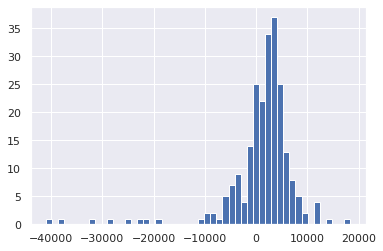

In [148]:
# for Ridge preds
errors = y_test - ridge_model.predict(X_test)
print(f'Mean: {errors.mean()}, std: {errors.std()}')
plt.hist(errors, bins=50);

Mean: 702.5210497023994, std: 7054.354100716458


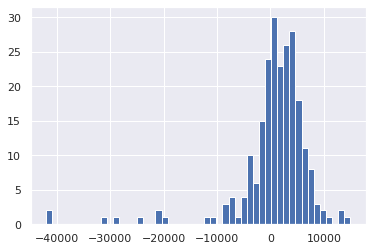

In [149]:
# for Lasso preds
errors = y_test - lasso_model.predict(X_test)
print(f'Mean: {errors.mean()}, std: {errors.std()}')
plt.hist(errors, bins=50);

In average, model underestimates a little (y_test is bigger than forecasts by __702__ instead of 0).

# Ideas for improvements
* differenced target instead of target
* non-linear algorithms (Trees, Neural Network)